## Final Project Submission

Please fill out:
* Student name: Sue Lim
* Student pace: self paced
* Scheduled project review date/time: May 15, 2023, 11:00 AM - 11:45 AM
* Instructor name: Mark Barbour
* Blog post URL: https://medium.com/@limsue9123/assumptions-and-diagnostics-for-linear-regression-bbb2ba25efaf


# I. Data Cleaning & Exploration

First of all, I clean King's county housing data before using it in regression analysis, by 1) dropping NULL values; 2) transforming the response and the predictor variables as appropriately; and 3) extracting state, county, and zipcode information from the address variable. Additionally, the relationship between the response variable and potentially predictor variables is explored using scatter plots and the correlation matrix.

In [1]:
# Import packages and the house sales data

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

df = pd.read_csv("data/kc_house_data.csv")
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,view,condition,grade,heat_source,sewer_system,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address,lat,long
0,7399300360,5/24/2022,675000.0,4,1.0,1180,7140,1.0,NO,NO,NO,NONE,Good,7 Average,Gas,PUBLIC,1180,0,0,40,1969,0,"2102 Southeast 21st Court, Renton, Washington ...",47.461975,-122.19052
1,8910500230,12/13/2021,920000.0,5,2.5,2770,6703,1.0,NO,NO,YES,AVERAGE,Average,7 Average,Oil,PUBLIC,1570,1570,0,240,1950,0,"11231 Greenwood Avenue North, Seattle, Washing...",47.711525,-122.35591
2,1180000275,9/29/2021,311000.0,6,2.0,2880,6156,1.0,NO,NO,NO,AVERAGE,Average,7 Average,Gas,PUBLIC,1580,1580,0,0,1956,0,"8504 South 113th Street, Seattle, Washington 9...",47.502045,-122.22520
3,1604601802,12/14/2021,775000.0,3,3.0,2160,1400,2.0,NO,NO,NO,AVERAGE,Average,9 Better,Gas,PUBLIC,1090,1070,200,270,2010,0,"4079 Letitia Avenue South, Seattle, Washington...",47.566110,-122.29020
4,8562780790,8/24/2021,592500.0,2,2.0,1120,758,2.0,NO,NO,YES,NONE,Average,7 Average,Electricity,PUBLIC,1120,550,550,30,2012,0,"2193 Northwest Talus Drive, Issaquah, Washingt...",47.532470,-122.07188


From the original dataset, I drop 44 records with NULL values.

In [2]:
# Drop records containing NULL values

print("Before dropping NULL values: " + str(len(df)) + " records")
df.dropna(axis = 0, inplace = True)
print("After dropping NULL values: " + str(len(df)) + " records")

Before dropping NULL values: 30155 records
After dropping NULL values: 30111 records


The following plots show that the price variable roughly follows the log normal distribution, so I use the log-transformed price variable for regression.

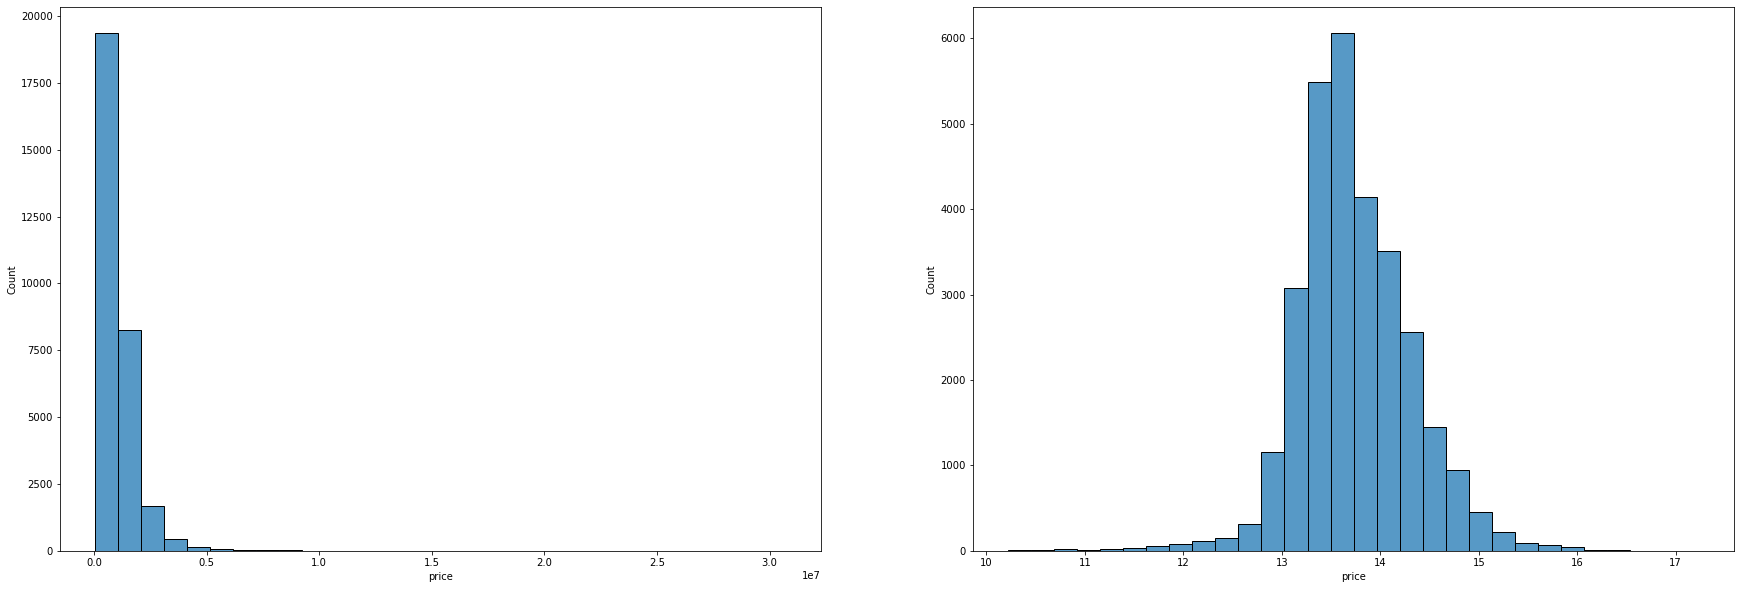

In [3]:
# Plot the distribution of the price variable and the log-transformed price variable

fig, axes = plt.subplots(ncols = 2, figsize = (30, 10))

sns.histplot(df["price"], bins = 30, ax = axes[0])
sns.histplot(np.log(df["price"]), bins = 30, ax = axes[1]);

The address variable contains useful information such as zipcode, county, and state which can potentially be used as predictor variables in the analysis. Therefore, I scrape the information.

In [4]:
# Scrape Zipcode, County, and State from the address variable

df["log_price"] = np.log(df["price"])
df["zipcode"] = df["address"].apply(lambda x: x[-20:-15])
df["county"] = df["address"].str.rsplit(',', 3).apply(lambda x: x[-3][1:])
df["state"] = df["address"].str.rsplit(',', 3).apply(lambda x: x[-2][:-5])

I clean the zipcode and county variables further so that the zipcodes or counties for which there are less than 30 observations are grouped as Others. This is to simplify the analysis.

In [5]:
df0 = df.copy()

index = df0["zipcode"].value_counts().reset_index()
zipcodes = index[index["zipcode"]>30]
df0["zipcode_clean"] = df0["zipcode"].apply(lambda x: x if x in zipcodes["index"].unique() else "Others")

index = df0["county"].value_counts().reset_index()
counties = index[index["county"]>30]
df0["county_clean"] = df0["county"].apply(lambda x: x if x in counties["index"].unique() else "Others")

Additional feature extraction includes 1) scraping transaction years from the transaction date variable, 2) turning the condition, view, and grade variables into scales, and 3) taking the later of year built and year renovated variables to create a proxy for how modern a home is.

In [6]:
df0["yr_transacted"] = df0["date"].apply(lambda x: int(x[-4:])) - 2020
df0["condition"] = df0["condition"].apply(lambda x: 
                                       1 if x == "Poor" else 
                                       (2 if x == "Fair" else 
                                        (3 if x == "Average" else 
                                         (4 if x == "Good" else 5)))) 
df0["view"] = df0["view"].apply(lambda x: 
                                       1 if x == "NONE" else 
                                       (2 if x == "FAIR" else 
                                        (3 if x == "AVERAGE" else 
                                         (4 if x == "GOOD" else 5))))

df0["grade"] = df0["grade"].apply(lambda x: int(x[:2]))

df0["yr_built_renovated"] = df0[["yr_built", "yr_renovated"]].max(axis = 1)

Lastly, I filter out outlier records states of which are outside Washington as they are likely to be erroneous records, and drop sale prices less than $100K as the data points do not appear to be credible.

In [7]:
df1 = df0[(df0["state"] == " Washington ") & (df0["price"] > 100000)]

The following plots are helpful in identifying which variables have linear relationships with the log-transformed price variable. We can see that variables such as the number of bathrooms, sqft of living areas linearly correlated with the log prices. This is not after controlling for all other potential predictor variables but good for preliminary investigation.

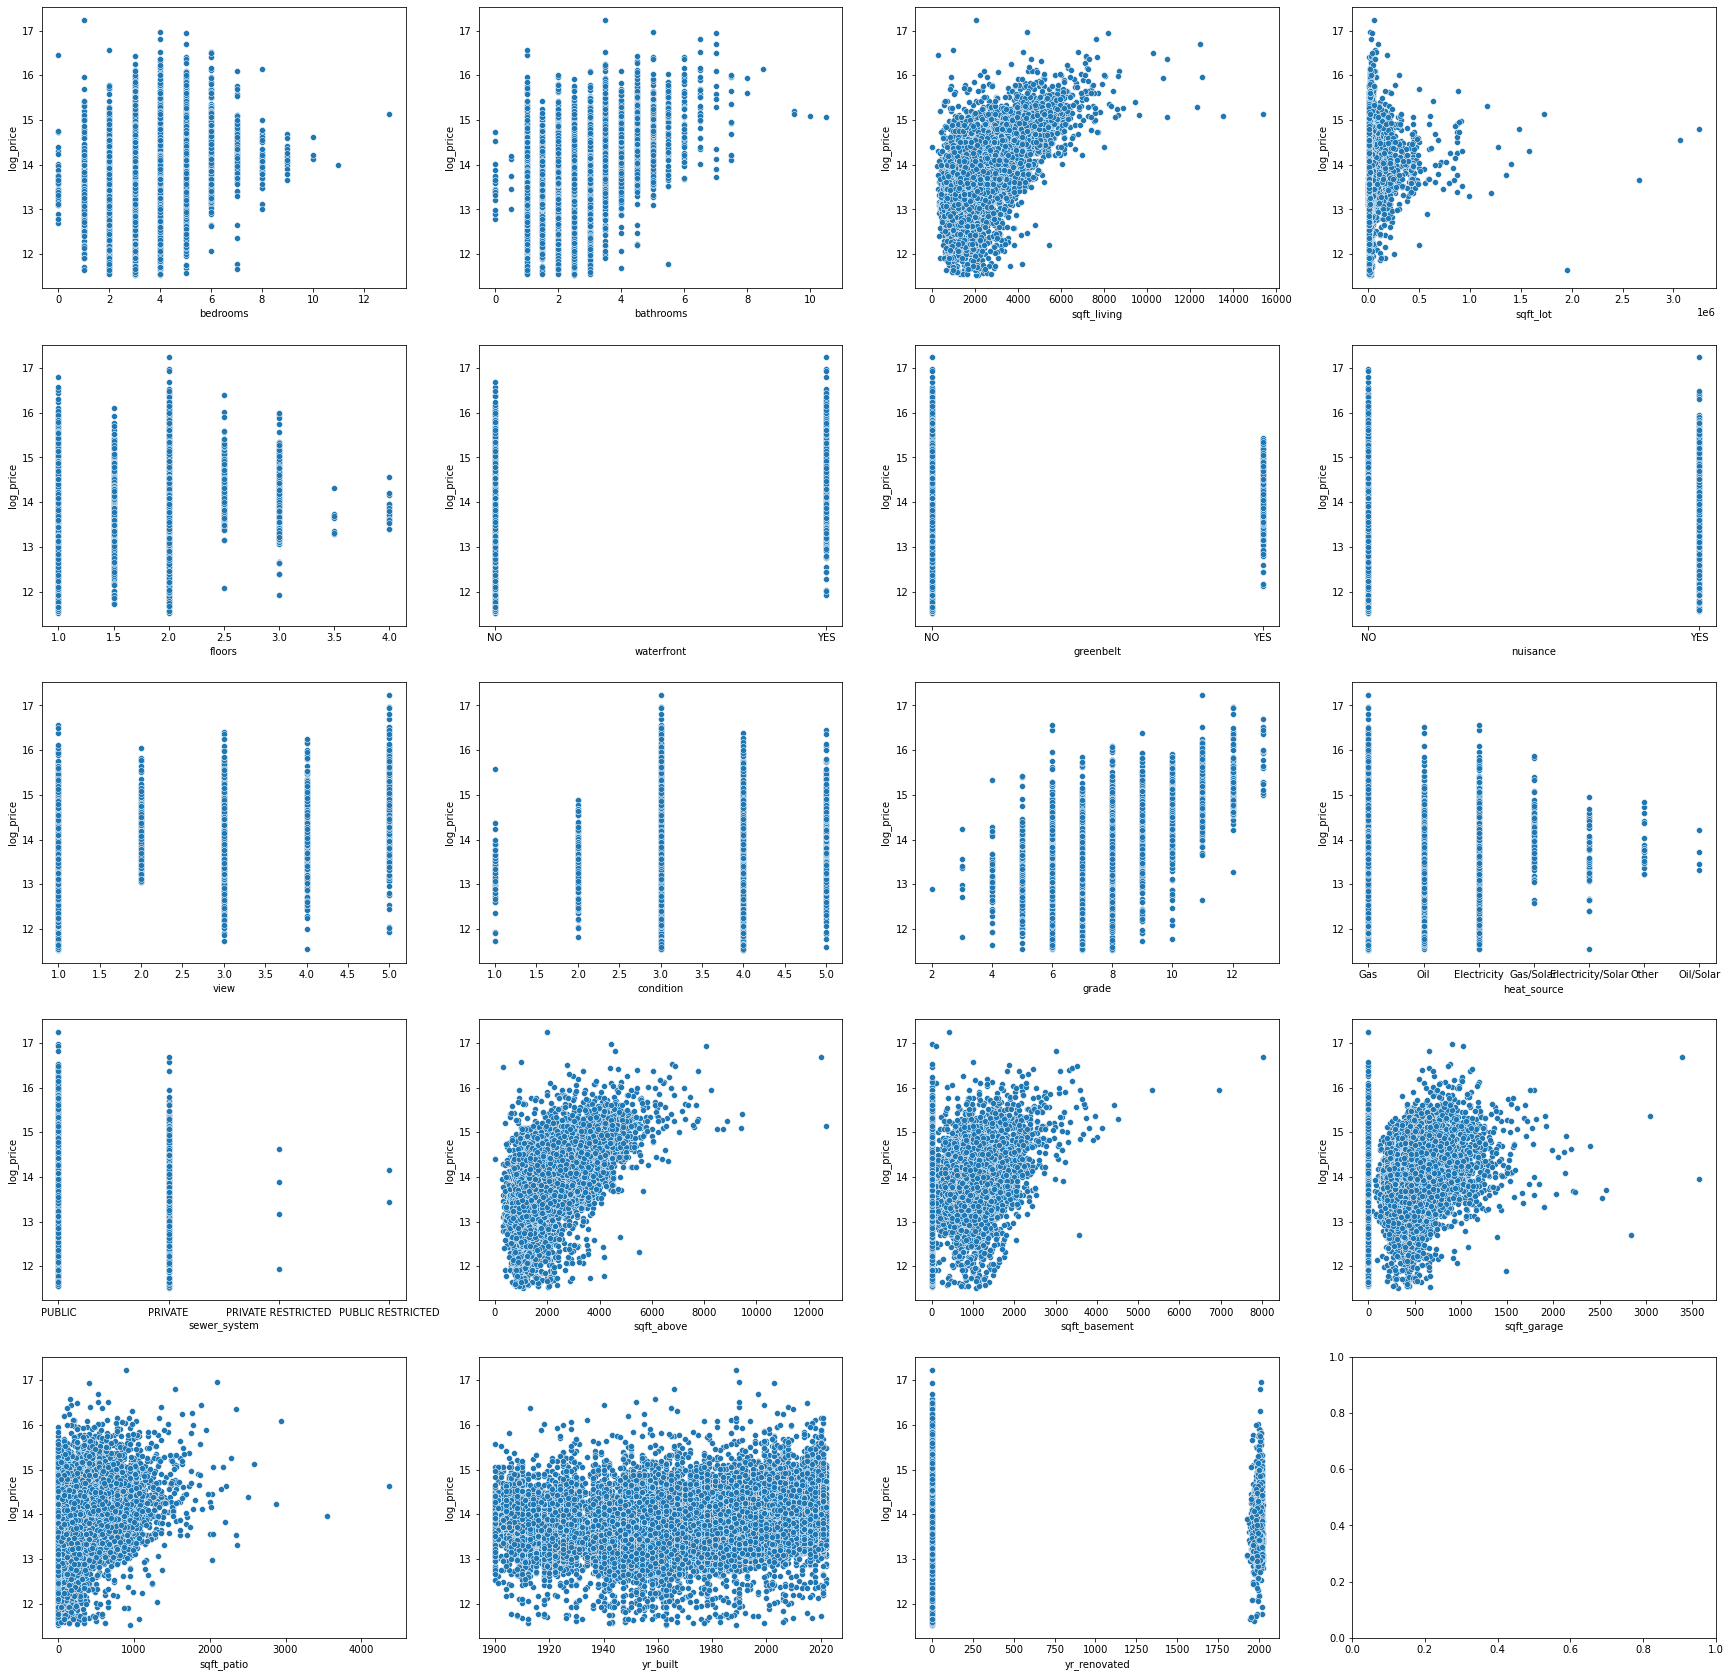

In [8]:
# Plot relationships between the log-transformed price variable and other variables

fig, axes = plt.subplots(nrows = 5, ncols = 4, figsize = (30, 30))

counter = 0
for i in range(25):
    if (df1.columns[i] in ["id", "date", "price", "address", "lat", "long"]) == False:
        sns.scatterplot(x = df1.iloc[:, i], y = df1["log_price"], ax = axes[np.floor(counter / 4).astype(int), counter % 4])
        counter += 1

The following correlation matrix shows the relationships more concretely. Sqft of living areas is the variable that is correlated most with the log prices. The number of bathrooms is also correlated with the log prices, but it also is with the sqft of living areas. Therefore, I use the sqft of living areas and sqft of lots but do not use the number of bedrooms or the number of bathrooms in the regression analysis. In addition, variables such as view or home condition have some correlation with the log prices too so I include them as predictor variables.

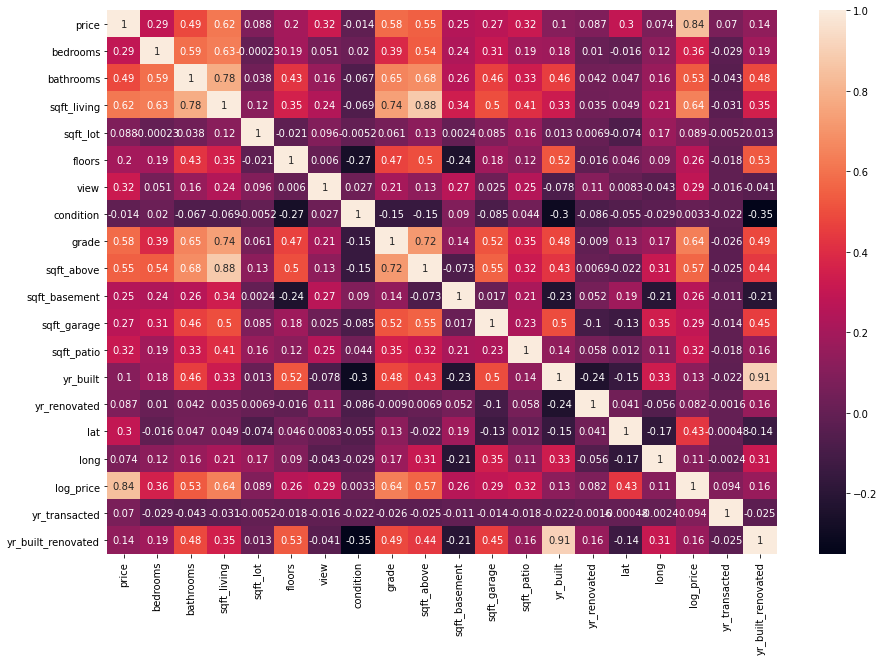

In [9]:
# Create a correlation matrix to see if there is any pair of variables with correlation > 0.8

fig, ax = plt.subplots(figsize = (15, 10))
sns.heatmap(df1.drop("id", axis = 1).corr(), annot = True, ax = ax);

Based on the investigations above, I pick potential predictor variables and prep the data to be used in the regression analysis.

In [10]:
# Log-transform the price variable and create dummy variables and an initial set of predictor variables

y = df1["log_price"]

vars_numeric = df1[["sqft_living", "sqft_lot", "yr_transacted", "condition", "view", "grade"]]

vars_character = pd.get_dummies(df1[["waterfront", "greenbelt", "nuisance"]])
vars_character = vars_character[vars_character.columns[vars_character.columns.str.endswith("YES")]]

vars_zipcode = pd.get_dummies(df1[["zipcode_clean"]], drop_first = True)
vars_county = pd.get_dummies(df1[["county_clean"]], drop_first = True)

X = pd.concat([vars_numeric, vars_character, vars_zipcode, vars_county], axis = 1)

As the last step, I split the data into a training dataset and a test dataset.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 123)

# II. Regression Result & Model Selection

I run three different potential models to see which one performs the best. 

The first model uses the following predictor variables: sqft of living areas, sqft of lots, transaction year, home condition, view, building grade, waterfront, greenbelt, and nuisance. The R-squared on the training dataset and on the validation data is 51.4% and 50.8% respectively.

In [12]:
# First regression model and result

model_1 =  sm.OLS(y_train, sm.add_constant(X_train.iloc[:, ~((X_train.columns.str.startswith("zipcode")) | (X_train.columns.str.startswith("county")))]))
results_1 = model_1.fit(cov_type = "HC3")
print(results_1.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.509
Method:                 Least Squares   F-statistic:                     1981.
Date:                Thu, 25 May 2023   Prob (F-statistic):               0.00
Time:                        22:32:57   Log-Likelihood:                -10783.
No. Observations:               21837   AIC:                         2.159e+04
Df Residuals:                   21827   BIC:                         2.167e+04
Df Model:                           9                                         
Covariance Type:                  HC3                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             11.3866      0.032    359.

In [13]:
# R-squared on validation data

r2_validation_1 = round(r2_score(y_test, results_1.predict(sm.add_constant(X_test.iloc[:, ~((X_test.columns.str.startswith("zipcode")) | (X_test.columns.str.startswith("county")))]))) * 100, 1)
print(f"R-squared on validation data is {r2_validation_1}%")

R-squared on validation data is 52.2%


The second model uses the same predictor variables as the first model, and also uses county dummy variables. This is to account for price differences among different counties. The R-squared on the training dataset and on the validation dataset is 71.5% and 71.1% respectively. This demonstrates a huge improvement from the first model, and implies that homes with the same conditions, sqft, etc. may have different prices depending on which county they are located in. 

In [14]:
# Second regression model and result using County instead of Zipcode

model_2 = sm.OLS(y_train,  sm.add_constant(X_train.iloc[:, ~X_train.columns.str.startswith("zipcode")]))
results_2 = model_2.fit(cov_type = "HC3")
print(results_2.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.710
Model:                            OLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                     1029.
Date:                Thu, 25 May 2023   Prob (F-statistic):               0.00
Time:                        22:32:59   Log-Likelihood:                -5047.3
No. Observations:               21837   AIC:                         1.019e+04
Df Residuals:                   21790   BIC:                         1.056e+04
Df Model:                          46                                         
Covariance Type:                  HC3                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [15]:
# R-squared on validation data

r2_validation_2 = round(r2_score(y_test, results_2.predict(sm.add_constant(X_test.iloc[:, ~X_test.columns.str.startswith("zipcode")]))) * 100, 1)
print(f"R-squared on validation data is {r2_validation_2}%")

R-squared on validation data is 72.5%


The third model uses zipcodes instead of counties. The R-squared on the training dataset and the validation dataset is 75.5% and 74.6% respectively.

Among the three models, I pick the third model as the R-squared is highest and AIC & BIC are the lowest.

In [16]:
# Third regression model and result

model_3 = sm.OLS(y_train, sm.add_constant(X_train.iloc[:, ~X_train.columns.str.startswith("county")]))
results_3 = model_3.fit(cov_type='HC3')
print(results_3.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     710.6
Date:                Thu, 25 May 2023   Prob (F-statistic):               0.00
Time:                        22:33:01   Log-Likelihood:                -3465.8
No. Observations:               21837   AIC:                             7098.
Df Residuals:                   21754   BIC:                             7761.
Df Model:                          82                                         
Covariance Type:                  HC3                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   11.6792 

In [17]:
# R-squared on validation data

r2_validation_3 = round(r2_score(y_test, results_3.predict(sm.add_constant(X_test.iloc[:, ~X_test.columns.str.startswith("county")]))) * 100, 1)
print(f"R-squared on validation data is {r2_validation_3}%")

R-squared on validation data is 76.4%


Below shows how the model coefficients can be interpreted.

In [18]:
# Interpret the coefficients

print(f"Compared to the price of ${np.round(np.exp(results_3.params[0]))} with values of 0 for all predictor variables:")
for i in range(1, 7):
    print(f"For each increase of 1 unit in {results_3.params.reset_index().iloc[i, 0]}, the housing price increases by {np.round((np.exp(results_3.params[i]) - 1) * 100, 2)}%.")

print(f"\nCompared to houses without a feature:")    
for i in range(7, len(results_3.params)):
    print(f"If {results_3.params.reset_index().iloc[i, 0]} is Yes, the housing price increases by {np.round((np.exp(results_3.params[i]) - 1) * 100, 2)}%.")

Compared to the price of $118087.0 with values of 0 for all predictor variables:
For each increase of 1 unit in sqft_living, the housing price increases by 0.02%.
For each increase of 1 unit in sqft_lot, the housing price increases by 0.0%.
For each increase of 1 unit in yr_transacted, the housing price increases by 14.9%.
For each increase of 1 unit in condition, the housing price increases by 6.35%.
For each increase of 1 unit in view, the housing price increases by 5.59%.
For each increase of 1 unit in grade, the housing price increases by 10.11%.

Compared to houses without a feature:
If waterfront_YES is Yes, the housing price increases by 32.7%.
If greenbelt_YES is Yes, the housing price increases by 5.12%.
If nuisance_YES is Yes, the housing price increases by -4.09%.
If zipcode_clean_98002 is Yes, the housing price increases by -9.28%.
If zipcode_clean_98003 is Yes, the housing price increases by -4.53%.
If zipcode_clean_98004 is Yes, the housing price increases by 223.9%.
If z

I add partial regression plots below. A partial regression plot attempts to show the effect of adding another variable to a model that already has one or more independent variables. The plots show the relationships between each predictor variable and the log price variable after controlling for impact of all other predictor variables.

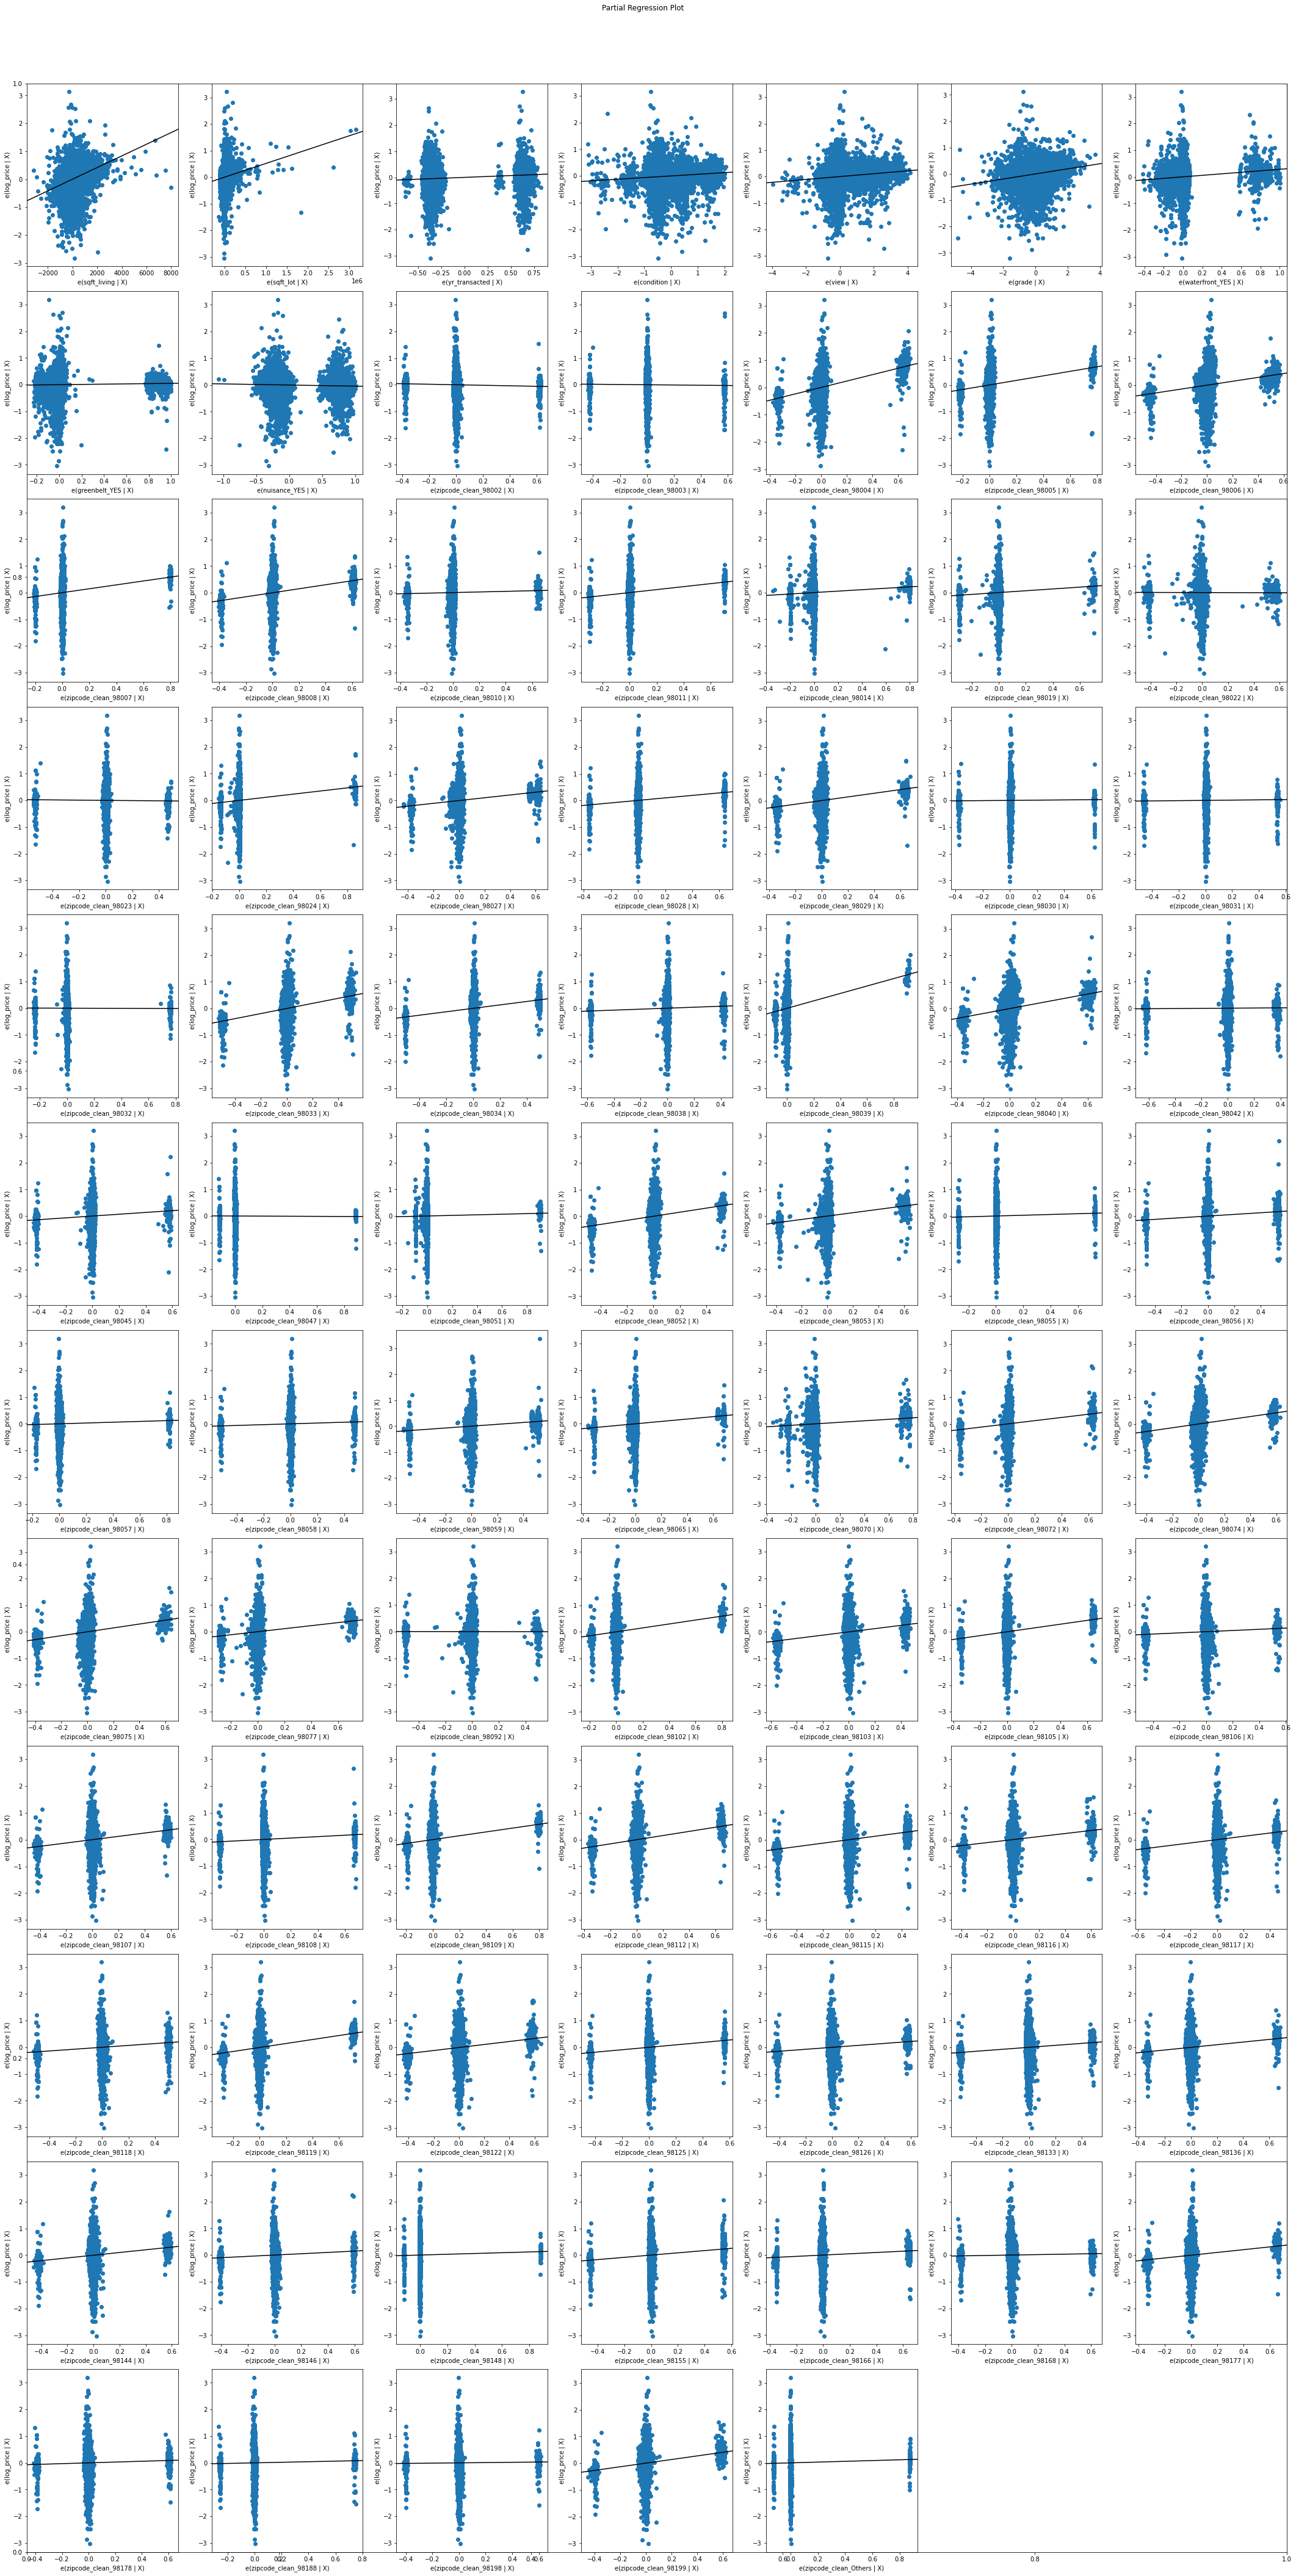

In [19]:
# Plot partial regression plot to diagnose the effect of of each predictor variable after controlling for other variables

fig, ax = plt.subplots(figsize = (30, 60))
sm.graphics.plot_partregress_grid(results_3, exog_idx = list(X_train.iloc[:, ~X_train.columns.str.startswith("county")].columns), grid = (12, 7), fig = fig)
plt.show()

# III. Conclusion & Next Steps

To conclude, I recommend using the following as predictor variables. In particular, the first four affect housing prices by more than 10%.
- Zipcode
- SQFT of Living Area 
- Waterfront Location
- Transaction Year
- Building Grade
- Home Condition
- View
- Greenbelt Location
- Nuisance Location
- SQFT of Lot

Additionally, the following are possible next steps.
- Find additional characteristics that explain the housing sale prices, such as macro economic indicators (interest rates, economic cycle, etc.).
- Investigate and verify the accuracy of outlier observations. In particular, there are transactions where the prices are less than $100K which are excluded in this analysis.